# 0. Imports

In [1]:
import pandas as pd
import numpy as np
import requests as rq
import bs4
import lxml
import os
import time
from dateutil import parser

# 1. Data collection

## 1.1 Get the list of places

In [2]:
home_url = "https://www.atlasobscura.com"
page_url = "https://www.atlasobscura.com/places?sort=likes_count"
initial_result = rq.get(page_url)

In [2]:
top_places = []
N = 400

In [9]:
for _ in range(N):
    
    if _ % 50 == 0: # print process
        print(page_url)
    
    time.sleep(0.01) # sleep to avoid too many requests
    result = rq.get(page_url)
    soup = bs4.BeautifulSoup(result.text)
    
    # acess all 18 cards of the current page
    cards = soup.find_all("div", {"class": "col-md-4 col-sm-6 col-xs-12"})
    # len(cards) = 18
    
    # only store the href for each card
    page_urls = [card.find_all("a", {"class": "content-card content-card-place"})[0].get('href') 
                 for card in cards]
    
    top_places.append(page_urls)
    
    # acess url for the next page from the "next page" button
    next_page = soup.find_all("a", {"rel": "next"})[0].get('href')
    page_url = home_url + next_page
    

https://www.atlasobscura.com/places?page=219&sort=likes_count
https://www.atlasobscura.com/places?page=269&sort=likes_count
https://www.atlasobscura.com/places?page=319&sort=likes_count
https://www.atlasobscura.com/places?page=369&sort=likes_count


In [26]:
# write all urls to one .txt file
with open("/home/enno/Documents/GitHub/G32HW3/htmls/places.txt", 'w+') as f:
    for page in top_places:
        for place in page:
            f.write(home_url + place + '\n')

## 1.2 Crawl places

In [ ]:
# read and split urls in 400 sets of 18
with open("/home/enno/Documents/GitHub/G32HW3/htmls/places.txt", 'r+') as f:
    top_places = np.array_split(f.readlines(), 400)

In [37]:
# method for writing .html files for the set of urls for one page
def crawl_places(urls_per_page,
                 parent_dir="/home/enno/Documents/GitHub/G32HW3/htmls",
                 page_ix=1):
    
    # parameter parent_dir has to be set according to user specs
    
    # create folder
    directory = f'page_{page_ix}'
    path = os.path.join(parent_dir, directory)
    os.mkdir(path)

    for place_ref in urls_per_page:
        place_ref = place_ref[:-1]
        
        time.sleep(5) # sleep to avoid too many requests error
        page = rq.get(place_ref)
        place_name = place_ref.split('/')[-1].replace('-', '_')
        
        print(place_name)

        with open(f'{path}/{place_name}.html', 'wb+') as f:
            f.write(page.content)


In [32]:
for ix, page in enumerate(top_places[294:], start=295):
    if ix % 25 == 0: print('Page', ix)
    crawl_places(page, page_ix=ix)

NameError: name 'top_places' is not defined

## 1.3  Parse downloaded pages

In [30]:
def get_place_attributes(soup, tsv_dir):
    placeName = str(soup.find_all('h1',{'class':'DDPage__header-title'})[0].contents[0])
    placeTags = str(soup.find_all('div',{'class':'DDPage__header-place-location'})[0].contents[0].text).split(sep=',')
    numPeopleVisited = int(soup.find_all('div', {'class':'title-md item-action-count'})[0].contents[0])
    numPeopleWant = int(soup.find_all('div', {'class':'title-md item-action-count'})[-1].contents[0])
    placeDesc = soup.find_all('div', {'class':'DDP__body-copy'})[0].text.strip()
    placeShortDesc = soup.find_all('h3', {'class':'DDPage__header-dek'})[0].text
    placeAddress = soup.find_all('address', {'class':'DDPageSiderail__address'})[0].contents[3].text.partition('\n')[0]
    list_Alt_Long = soup.find_all('address', {'class':'DDPageSiderail__address'})[0].contents[3].text
    placeAlt = int(float(list_Alt_Long.split('\n', 1)[1].split()[0].replace(',', ' ')))
    placeLong = int(float(list_Alt_Long.split('\n', 1)[1].split()[1].replace(',', ' ')))


    placeEditors = soup.find_all('div', {'class':'js-editor-list hidden'})
    if len(placeEditors) == 0:
        placeEditors = list()
    else:
        placeEditors = soup.find_all('div', {'class':'js-editor-list hidden'})[0].text.split()
    for elem in placeEditors:
        if len(elem) == 1:
            placeEditors.remove(elem)


    placePubDate = soup.find_all('div', {'class':'DDPContributor__name'})
    if len(placePubDate) > 0:
        placePubDate = placePubDate[0].text.replace(',', ' ')
        placePubDate = parser.parse(placePubDate).date() # %y-%m-%d
    else:
        placePubDate = ''
        
    card_grids = soup.find_all('div', 
                               {'class': "card-grid CardRecircSection__card-grid js-inject-gtm-data-in-child-links"
    })
    
    if len(card_grids) >= 2:
        second_card = card_grids[1]
        placeRelatedPlaces = [button.get("data-place-title") 
                              for button in second_card.find_all('div', 
                                                                 {'class': 'Card__action-btns vue-js-been-there-everywhere-place'})]
    else:
        placeRelatedPlaces = ''

    
    if len(card_grids) >= 3:
        third_card = card_grids[2]
        placeRelatedLists = [related_list.text.strip()
                             for related_list in third_card.find_all('h3', 
                                                                     {'class': 'Card__heading --content-card-v2-title js-title-content'})]
    else:
        placeRelatedLists = ''

    placeURL = soup.find_all('link', {'rel': "canonical"})[0].get('href')

    df =pd.DataFrame({'placeName' : placeName, 
                      'placeTags' : [placeTags],
                      'numPeopleVisited': numPeopleVisited,
                      'numPeopleWant': numPeopleWant,
                      'placeDesc': placeDesc,
                      'placeShortDesc': placeShortDesc,
                      'placeAddress': placeAddress, 
                      'placeAlt': placeAlt,
                      'placeLong': placeLong,
                      'placeEditors': [placeEditors],
                      'placePubDate': placePubDate,
                      'placeRelatedPlaces': [placeRelatedPlaces],
                      'placeRelatedLists': [placeRelatedLists],
                      'placeURL': placeURL})
    
    file_name = '_'.join(placeName.lower().split()).replace('/', '_')
    
    data = df.to_csv(f'{tsv_dir}{file_name}.tsv', sep="\t")
       

In [31]:
path_to_html_dir = '/home/enno/Documents/GitHub/G32HW3/htmls/'
path_to_tsv_dir = '/home/enno/Documents/GitHub/G32HW3/tsvs/'

pages = sorted(os.listdir(path_to_html_dir), key=lambda dir_name: int(dir_name.split('_')[-1]))

for current_page in pages:
    path_to_current_page = os.path.join(path_to_html_dir, current_page)
    places_per_page = os.listdir(path_to_current_page)
    
    for current_place in places_per_page:
        path_to_current_place = os.path.join(path_to_current_page, current_place)
        
        with open(path_to_current_place, 'rb') as f:
            soup = bs4.BeautifulSoup(f.read(), 'lxml') 
            get_place_attributes(soup, path_to_tsv_dir)

In [19]:
# testing
path_to_file = '/home/enno/Documents/GitHub/G32HW3/htmls/page_71/our_lord_in_the_attic.html'
with open(path_to_file, 'rb') as f:
    soup = bs4.BeautifulSoup(f.read(), 'lxml')

get_place_attributes(soup, '')

IndexError: list index out of range

In [5]:
file = '/home/enno/Documents/GitHub/G32HW3/tsvs/abandoned_jazzland.tsv'

data = pd.read_csv(file, delimiter='\t')    
data

,Unnamed: 0,placeName,placeTags,numPeopleVisited,numPeopleWant,placeDesc,placeShortDesc,placeAddress,placeAlt,placeLong,placeEditors,placePubDate,placeRelatedPlaces,placeRelatedLists,placeURL
0,0,Abandoned Jazzland,"['New Orleans', ' Louisiana']",608,4140,"On August 29th, 2005, Hurricane Katrina struck...",A theme park that suffered massive flooding du...,"12310 Six Flags ParkwayNew Orleans, Louisiana,...",30,-89,"['jasminjcamacho', 'betsywilson', 'robferraz',...",2013-02-07,"['Jungle Habitat', 'Lake Shawnee Amusement Par...","['A World Tour of Abandoned Amusement Parks', ...",https://www.atlasobscura.com/places/six-flags-...


In [12]:
from nltk.stem import *
from nltk.stem.snowball import SnowballStemmer
from collections import Counter
# from conda import Reduce

stemmer = PorterStemmer()
snowstem = SnowballStemmer('english')

[stemmer.stem(word) for word in data.loc[0].placeShortDesc.split(' ')]

['a',
 'theme',
 'park',
 'that',
 'suffer',
 'massiv',
 'flood',
 'dure',
 'katrina',
 'wa',
 'abandoned,',
 'and',
 'now',
 'prove',
 'irresist',
 'to',
 'trespass',
 'explorers.\xa0']

In [1]:
[snowstem.stem(word) for word in data.loc[0].placeShortDesc.split(' ')]

NameError: name 'data' is not defined

In [14]:
def stem_text(txt):
    return [snowstem.stem(word) for word in txt.split(' ')]

data['list_words'] = data.placeShortDesc.apply(lambda row: stem_text(row))


,Unnamed: 0,placeName,placeTags,numPeopleVisited,numPeopleWant,placeDesc,placeShortDesc,placeAddress,placeAlt,placeLong,placeEditors,placePubDate,placeRelatedPlaces,placeRelatedLists,placeURL,list_words
0,0,Abandoned Jazzland,"['New Orleans', ' Louisiana']",608,4140,"On August 29th, 2005, Hurricane Katrina struck...",A theme park that suffered massive flooding du...,"12310 Six Flags ParkwayNew Orleans, Louisiana,...",30,-89,"['jasminjcamacho', 'betsywilson', 'robferraz',...",2013-02-07,"['Jungle Habitat', 'Lake Shawnee Amusement Par...","['A World Tour of Abandoned Amusement Parks', ...",https://www.atlasobscura.com/places/six-flags-...,"[a, theme, park, that, suffer, massiv, flood, ..."


## 7. Theoretical question

An imaginary university is interested in accepting some of the applicants for positions to study the Master of Data Science there. Unfortunately, only a few spots are available, so the university requires students to take some exams. Students are then admitted based on how well they perform on these exams. For students to determine whether they have been successfully accepted to the university, the university wants to create a ranking list that includes every student's first name, last name, and total average on its course webpage. Students should be ranked in the list based on their average points in descending order. For example, if two students have the same average punctuation, they should be sorted in ascending order using their first and last names. University will give you the students' information in 'ApplicantsInfo.txt', and you should provide them with the ranking list in another .txt file and name it as 'RankingList.txt' . Kindly help this university in preparing this ranking list.


   1 Try solving the problem mentioned above using three different sorting algorithms (do not use any MapReduce algorithm). (Note: Built-in Python functions (like .mean, .sort, etc.) are not allowed to be used. You must implement the algorithms from scratch).
   
   2 What is the time complexity of each algorithm you have used?
   
   3 Evaluate the time taken for each of your implementations to answer the query stored in the ApplicantsInfo.txt file and visualize them.
   
   4 What is the most optimal algorithm, in your opinion, and why?
   
   5 Implement a sorting algorithm using MapReduce and compare it against the three algorithms previously implemented using the ApplicantsInfo.txt file.


In [2]:
n=10000 #number of students  
m=50 #number of exams
f=open('ApplicantsInfo.txt','r')
i=0
Applic={} #we want to create a dict of students
for line in f:
    line=line.split()
    if i==0: #skipping the first line because is the shape of the file
        i=1
    else:
        if n!=0:
            student=line[0]+' '+line[1]
            Applic[student]=[int(x) for x in line[2:m+2]]
            n-=1
f.close()

In [3]:
#Implementing an average function
def Average(x):
    aver=0
    for i in x:
        aver+=i
    
    return round(aver/len(x),2)

The running time of Average is $\Theta(N)$ where N is the length of the input x

In [4]:
#Creating a list of lists with the averages for each student
Rank=[]
for name in [stud for stud in Applic.keys()]: 
    Rank.append([name,Average(Applic[name])])

In [5]:
#Sorting algorithms for list of list
#if h=1 it sorts by scores, if h=0 it sorts by names
def InsertionSort(Rank,h): 
    
    for i in range(1,len(Rank)):
            temp= Rank[i]
            j=i-1
            while j>=0 and temp[h]>Rank[j][h]:
                     Rank[j+1] = Rank[j]
                     j-=1  
            Rank[j+1] = temp
    return Rank
############################################
def SelectionSort(Rank, h):
    
    for i in range(len(Rank)):
        M = i
        for j in range(i + 1,len(Rank)):
            if Rank[j][h] > Rank[M][h]:
                M = j
        (Rank[i], Rank[M]) = (Rank[M], Rank[i])
        
    return Rank
#############################################
def BubbleSort(Rank,h):
    change = 0
    for i in range(len(Rank)-1):
        for j in range(0, len(Rank)-i-1):
            if Rank[j][h] < Rank[j+1][h]:
                change = 1
                (Rank[j], Rank[j+1]) = (Rank[j+1], Rank[j])
        if change==0:
            return Rank
    return Rank

All of those algorithms have running time of $\Theta(N^2)$ where N is the length of the array in input

In [6]:
#Sorting the Applicants
import timeit 
unsorted=Rank.copy() #we want to keep the unsorted list to compare this non MapReduced algorithm with the MapReduced one
Times=[]
for Alg in [1,2,3]: # 1: InsertionSort, 2: SelectionSort, 3:BubbleSort
    Rank=unsorted.copy()
    start=timeit.default_timer() #this is to evaluate the time required to run the algorithm
    #sorting by exams averages
    if Alg==1:
        Rank=InsertionSort(Rank,1)
    elif Alg==2:
        Rank=SelectionSort(Rank,1)
    elif Alg==3:
        Rank=BubbleSort(Rank,1)
        
    #sorting duplicates by names
    i=0 
    while i <= (len(Rank)-1):
        j=1
        while (i+j)<(len(Rank)-1) and Rank[i][1]==Rank[i+j][1]: #to know the length of consecutive elements that have same score
            j+=1
        if j!=1: 
            #temp variable to store the correct order (we used [::-1] to sort in ascending order)
            if Alg==1:
                temp=InsertionSort([Rank[i+k] for k in range(j)],0)[::-1] 
            elif Alg==2:
                temp=SelectionSort([Rank[i+k] for k in range(j)],0)[::-1]
            if Alg==3:
                temp=BubbleSort([Rank[i+k] for k in range(j)],0)[::-1]
            for k in range(j):
                Rank[i+k]=temp[k] #changing the order in the Rank
            i+=j #just to skip the elements already changed
        else:
            i+=1

    stop=timeit.default_timer()
    Times.append(stop-start)


The running time to sort the duplicate is, in the worst case (i.e. all the scores are the same), equal to the running time of the sort method we use to sort by names so it is $\Theta(N^2)$.

So we have that to sort the Rank vector, in the worst case, we need a running time of $\Theta(2N^2)$

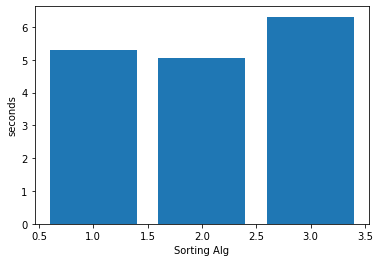

[5.294273658999998, 5.05121066199996, 6.31555033799998]

In [7]:
#Plotting the running times of each algorithm
import matplotlib.pyplot as plt
plt.ylabel('seconds')
plt.xlabel('Sorting Alg')
plt.bar([1,2,3],Times)
plt.show()
Times

As we can see, the InsertionSort algorithm is the best one of the non MapReduced algorithms

In [8]:
#implementing a MapReduced algorithm to confront the running times

def MergeSort(Rank,h):
    
    if len(Rank) == 1:
        return Rank

    l = len(Rank) // 2
    left = MergeSort(Rank[:l],h)
    right = MergeSort(Rank[l:],h)
    return merge(left, right,h)
#####################################
def merge(left, right,h):
    merged = []
    i = 0 
    j=0
    
    while i < len(left) and j < len(right):
        if left[i][h] > right[j][h]:
            merged.append(left[i])
            i += 1
        else:
            merged.append(right[j])
            j += 1
    merged.extend(left[i:])
    merged.extend(right[j:])
    return merged

In [9]:
Rank=unsorted #because the Rank list was already sorted by previous codes so I'll assign back the unsorted one
start=timeit.default_timer()
#sorting Rank by scores
Rank=MergeSort(Rank,1)
#sorting duplicates by names (Reusing previous algorithm)
i=0 
while i <= (len(Rank)-1):
        j=1
        while (i+j)<(len(Rank)-1) and Rank[i][1]==Rank[i+j][1]: #to know the length of consecutive elements that have same score
            j+=1
        if j!=1: 
            #temp variable to store the correct order (we used [::-1] to sort in ascending order)
            temp=MergeSort([Rank[i+k] for k in range(j)],0)[::-1] 
           
            for k in range(j):
                Rank[i+k]=temp[k] #changing the order in the Rank
            i+=j #just to skip the elements already changed
        else:
            i+=1
stop=timeit.default_timer()
Times.append(stop-start)

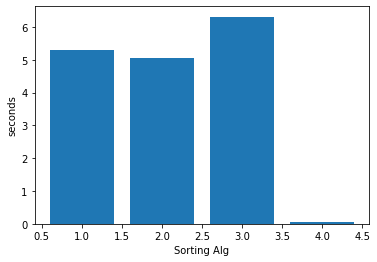

[5.294273658999998, 5.05121066199996, 6.31555033799998, 0.052451873999984855]

In [10]:
#Plotting the running times
plt.ylabel('seconds')
plt.xlabel('Sorting Alg')
plt.bar([1,2,3,4],Times)
plt.show()
Times

In [11]:
#TOP TEN STUDENTS
assert len(Rank)>=10

for i in range(10):
    print(Rank[i][0]+' '+str(Rank[i][1]))
    


Michael Hunley 26.02
Robert Seelbach 25.94
Felicia Payne 25.88
Karen Viard 25.88
Nakia Loza 25.82
Walter Jones 25.76
Jasmine Harrell 25.72
Mary Perrella 25.66
Stanley Hartrick 25.64
Samuel Winfrey 25.6


In [12]:
F=open('RankingList.txt','w') #creating a .txt file with the sorted Applicants
for i in range(len(Rank)):
    F.write(Rank[i][0]+' '+str(Rank[i][1])+'\n')
F.close()